In [ ]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
#from sbcustom import *

# statistics
import statsmodels.api as sm

In [ ]:
# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

In [ ]:
"""
Seaborn.objects statistical plotting custom functions.
boxplot, rangeplot
"""

import seaborn as sns
import seaborn.objects as so


def boxplot(df, x, y, color=None, alpha=0.1, marker="<"):
    
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est("median", errorbar=("pi", 50)), so.Dodge())
        .add(so.Dot(pointsize=8, marker=marker), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def rangeplot(df, x, y, color=None, alpha=0.1):

    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est("median", errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

샌프란시스코행 항공편의 도착은 왜 지연되었는가? nycflights13

출처: Modern Data Science with R (2e)
저자는 왜 아래와 같은 모형을 세웠을까?
다음은 좋은 모형인가?
Linear model: arr_delay ~ hour + origin + carrier + season + dow 
왜 다섯개 사용?
적절?
리니어하게 넣은게 적절?
훨씬 더 좋게 만들 수 있는지?

In [ ]:
# import the data
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# convert the date column to a datetime object
flights["time_hour"] = pd.to_datetime(flights["time_hour"])

# add a column for the day of the week 요일 뽑아내기 
flights["dow"] = (
    flights["time_hour"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

# add a column for the season
flights["season"] = np.where(flights["month"].isin([6, 7]), "summer", "other month") 
# 레벨이 두개인 카테고리를 만들었음

In [ ]:
# with assign
flights.assign(
    season = lambda x: np.where(x.month.isin([6, 7]), "summer", "other month")
)

# pd.eval
flights.assign(
    season = lambda x: np.where(pd.eval('x.month in [6, 7]'), "summer", "other month")
)

# apply with if-else
flights["month"].apply(lambda x: "summer" if x in [6, 7] else "other month")

# appply with match
def get_season(mth):
    match mth:
        case 6 | 7:
            return "summer"
        case _:
            return "other month"

flights["month"].apply(get_season)

# map with dictionary
flights["month"].map({6: "summer", 7: "summer"}).fillna("other month")

0         other month
1         other month
2         other month
             ...     
336773    other month
336774    other month
336775    other month
Name: month, Length: 336776, dtype: object

In [ ]:
# filter out the flights to SFO 여기만 분
sfo = flights.query('dest == "SFO" & arr_delay < 500').copy()

In [ ]:
from statsmodels.formula.api import ols
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()
mod.params

Intercept       -19.91
origin[T.JFK]     4.24
carrier[T.B6]    -9.59
                 ...  
dow[T.Fri]       -5.38
dow[T.Sat]      -11.17
hour              2.05
Length: 14, dtype: float64

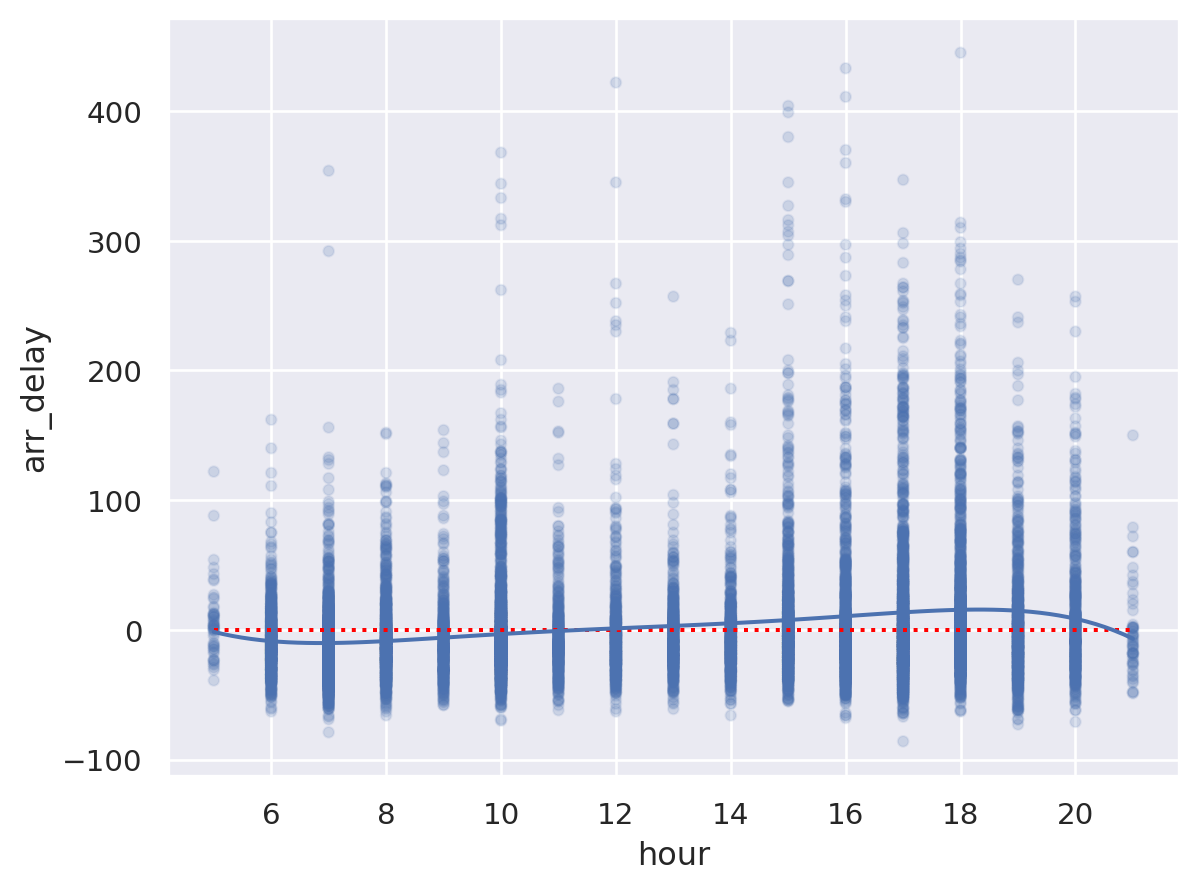

In [ ]:
(
    so.Plot(sfo, x='hour', y='arr_delay')
    .add(so.Dots(alpha=.1))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .add(so.Line(), so.PolyFit(5))
)

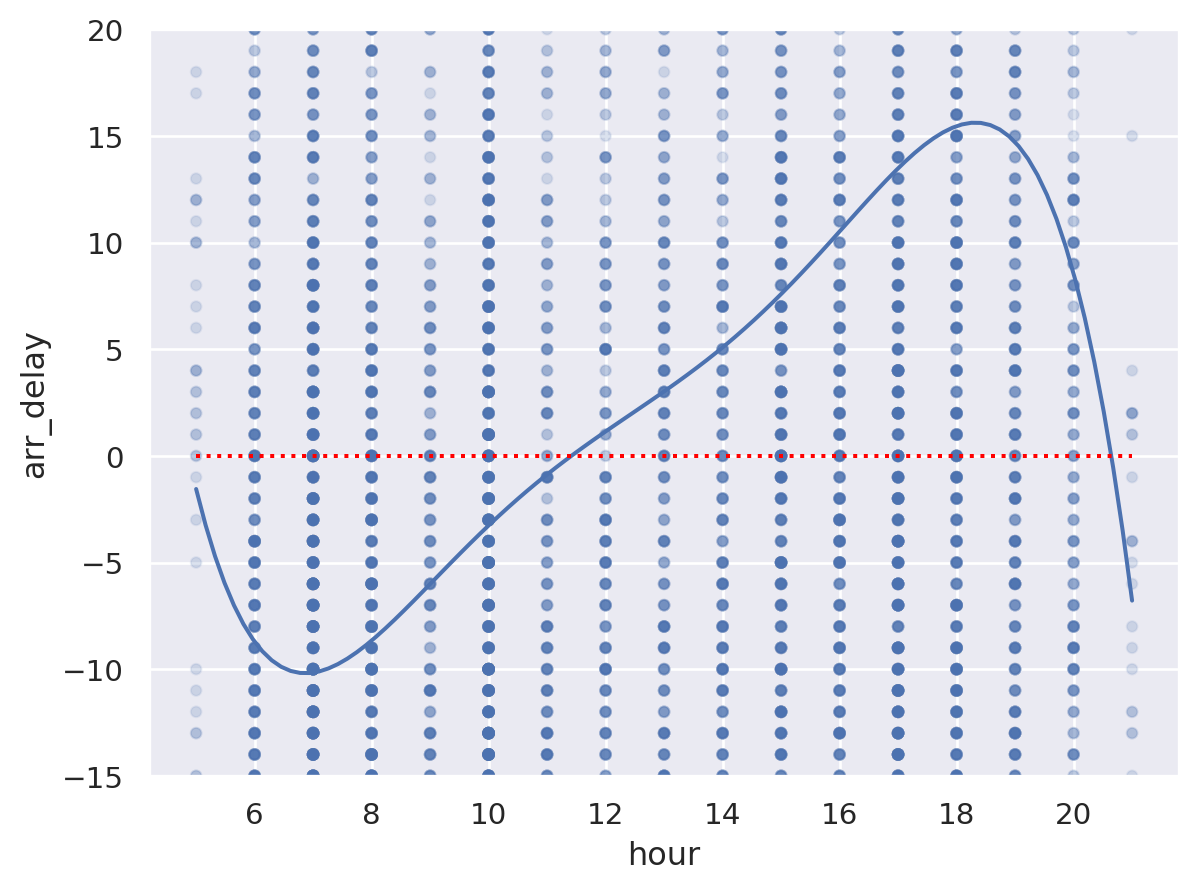

In [ ]:
(
    so.Plot(sfo, x='hour', y='arr_delay')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-15, 20))
    #.layout(size=(8.5, 5))
)

In [ ]:
sfo["resid"] = mod.resid  # Y - Y_hat

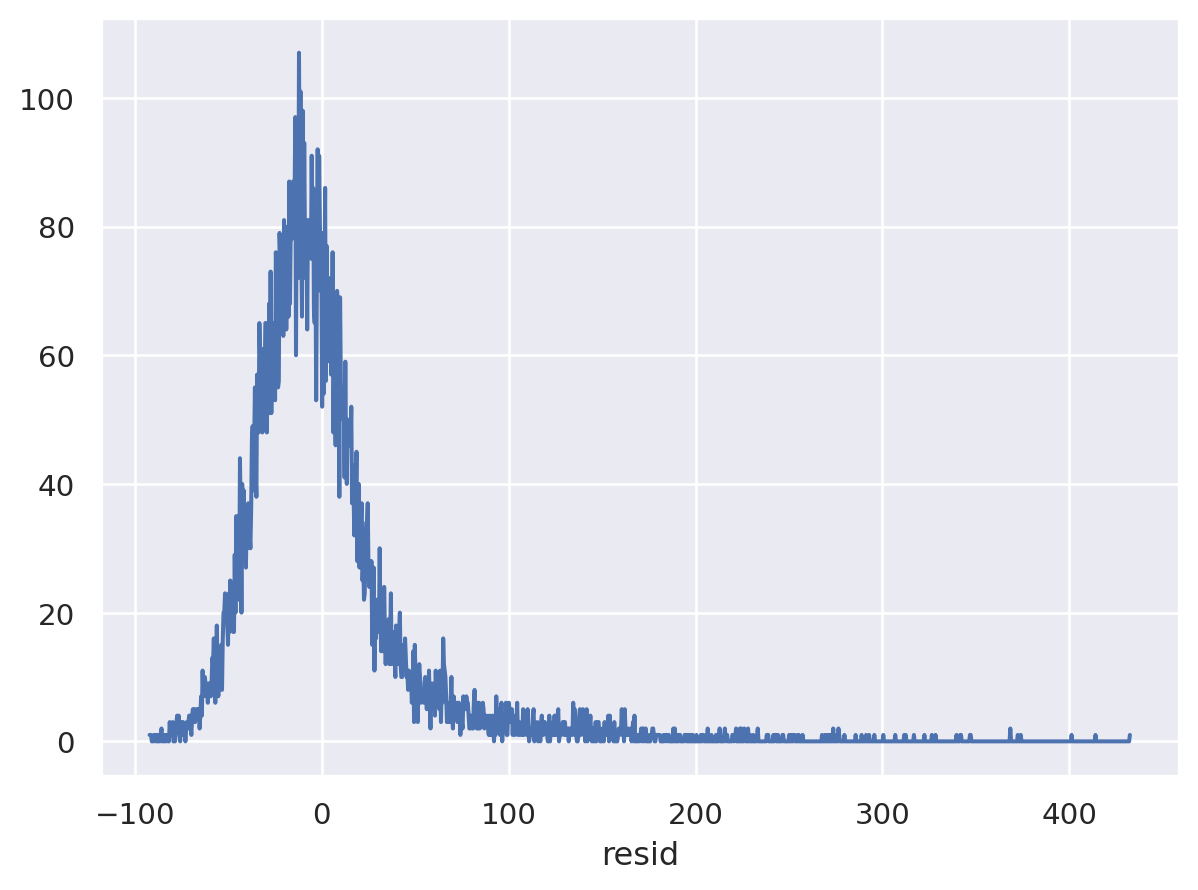

In [ ]:
(
    so.Plot(sfo, x='resid')
    .add(so.Line(), so.Hist(binwidth=.4))
    
)

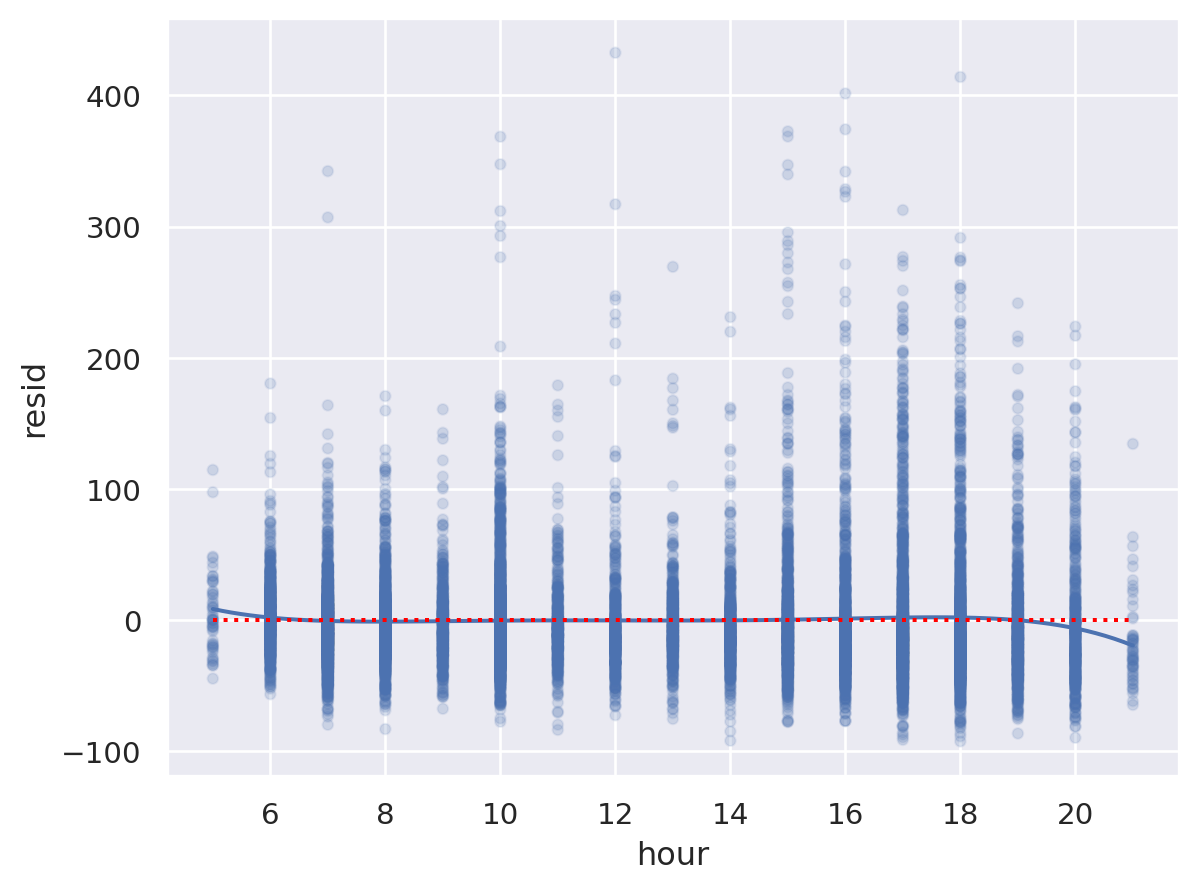

In [ ]:
(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
)

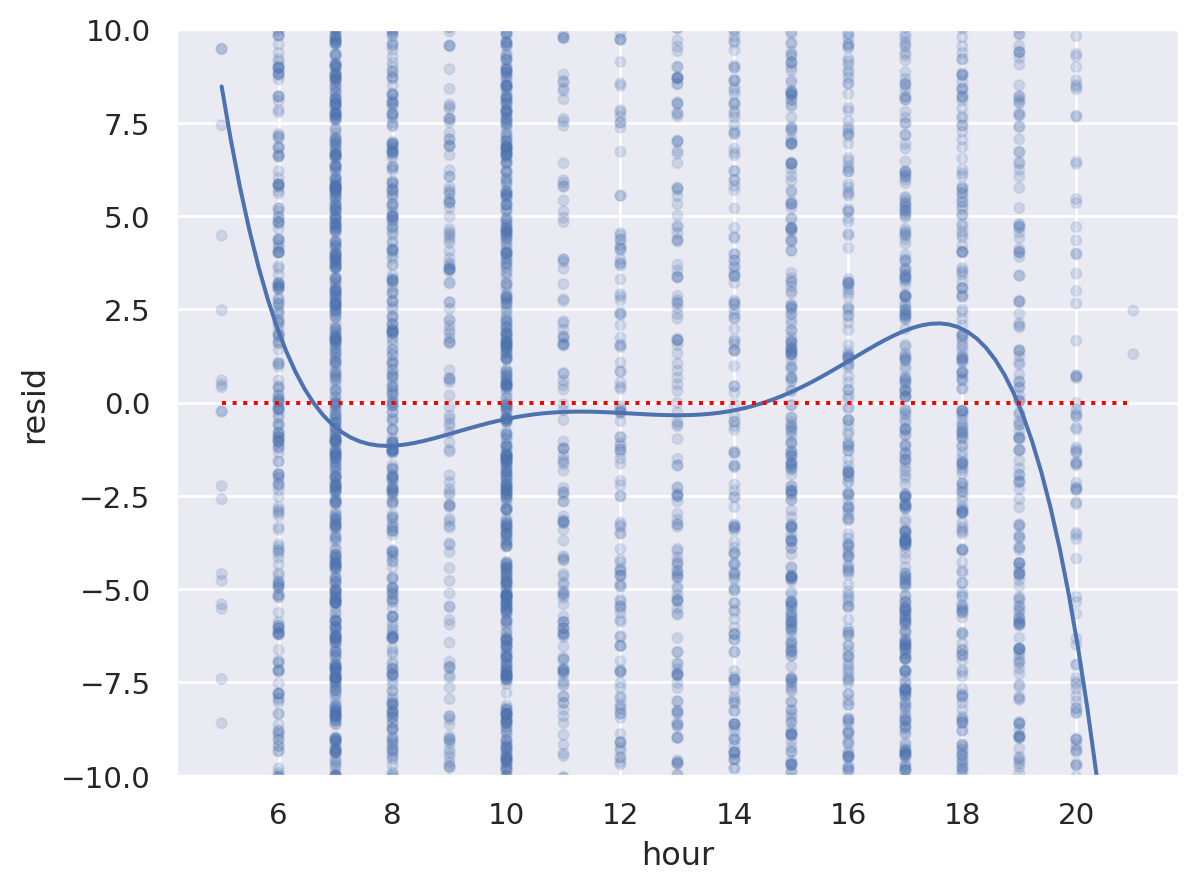

In [ ]:
(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-10,10))
)

잔차 분석하기. 해당 모델을 세웠을떄 잔차를 들여다보기
눈에 띄는게 없어서 확대해 보니 딜레이가 오후로 갈수록 늘었었음. 딜레이가 커져서 캔슬 된것도 있었음. 그 현상이 라인으로 보임.  아침에는 예측이 잘 안되고 있는데 오후에좀 예측이 잘 되다가 오후 두시 넘어가니까 예측이 잘 안됨. 해당 패턴이 나오기 시작함. hour만으로는 예측이 안되는 부분이 있다는것을 시사함.

In [ ]:
hour = rangeplot(sfo, x="hour", y='resid')
origin = rangeplot(sfo, x="origin", y='resid')
carrier = rangeplot(sfo, x="carrier", y='resid')
season = rangeplot(sfo, x="season", y='resid')
dow = rangeplot(sfo, x="dow", y='resid')

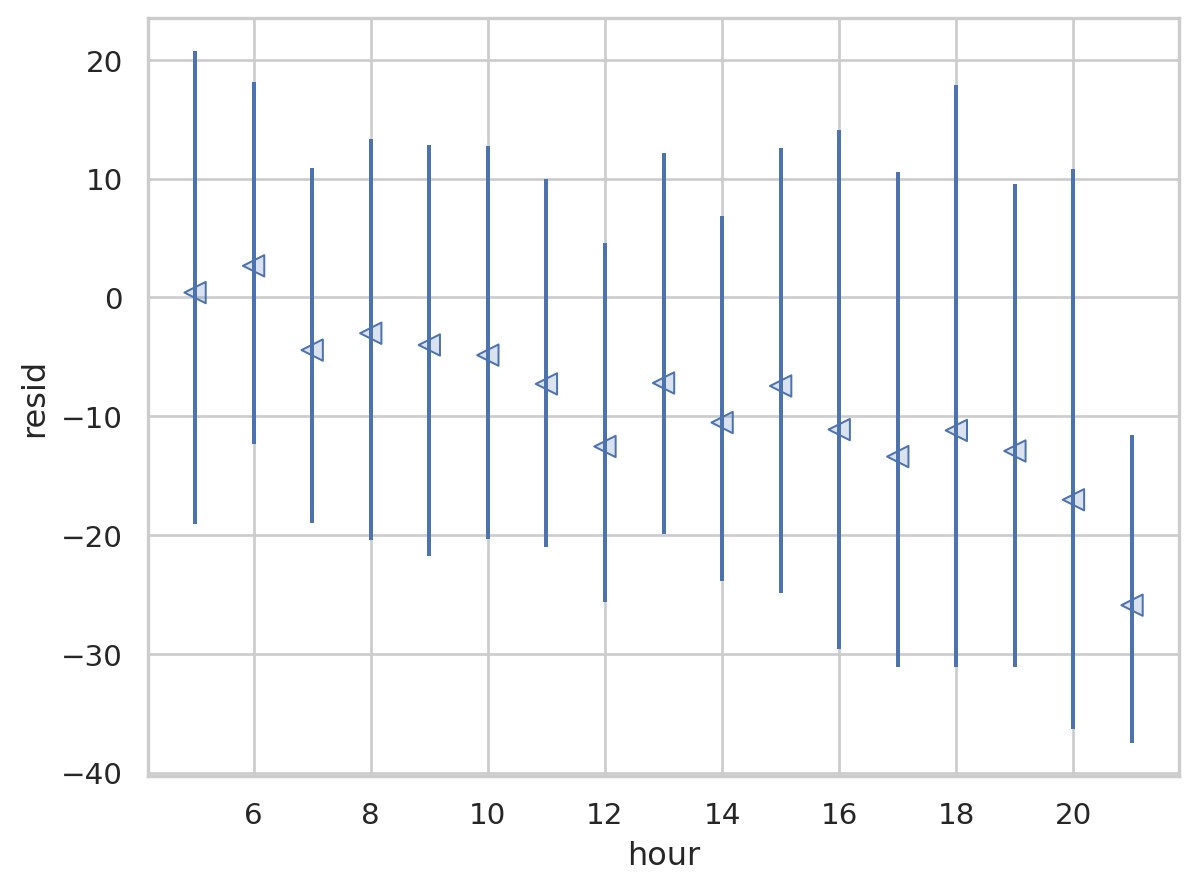

In [ ]:
hour

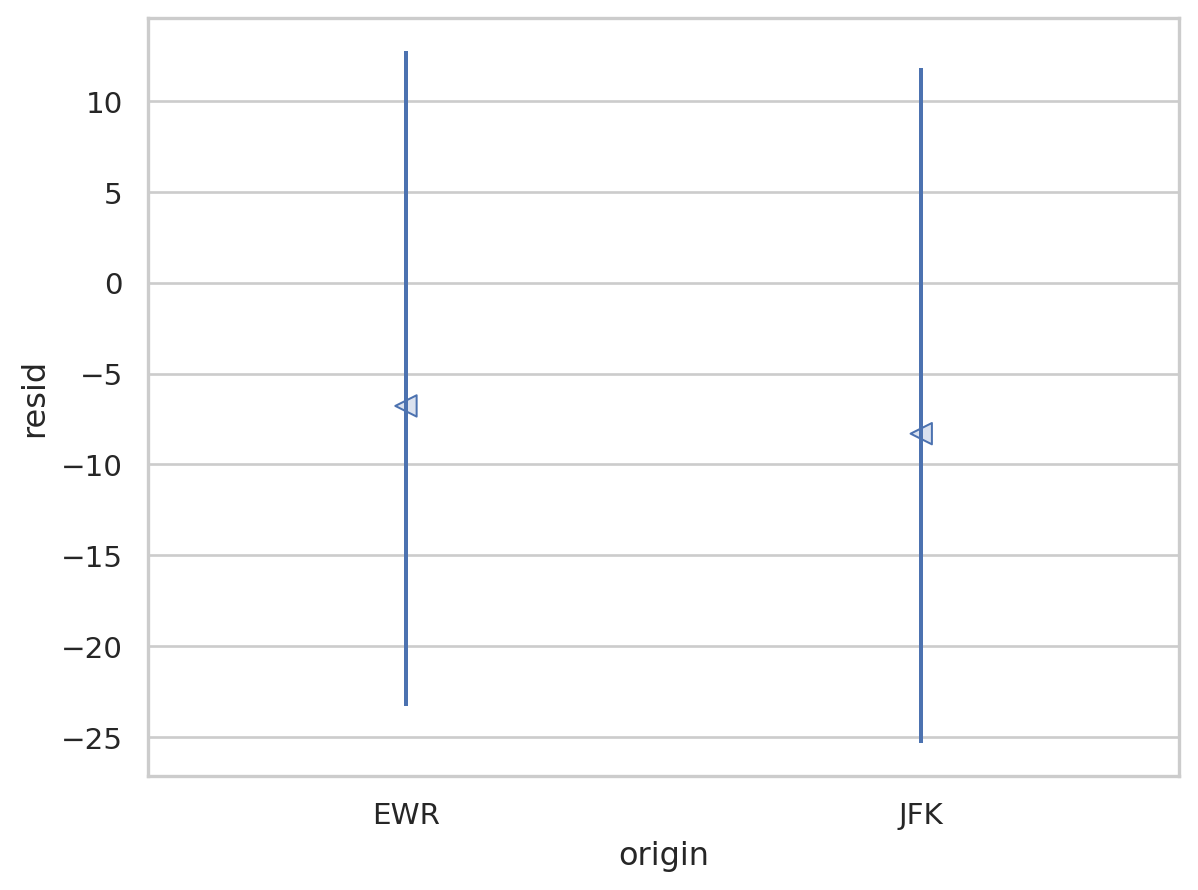

In [ ]:
origin

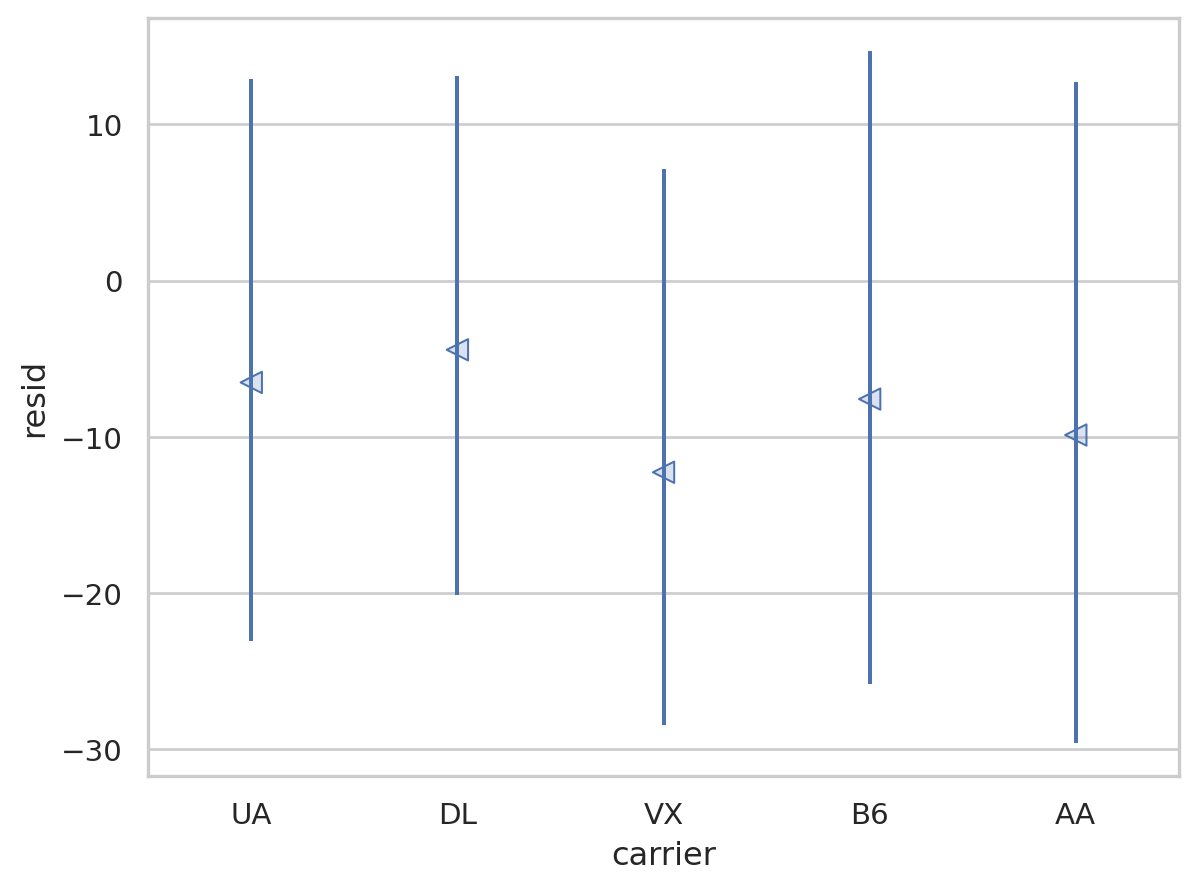

In [ ]:
carrier

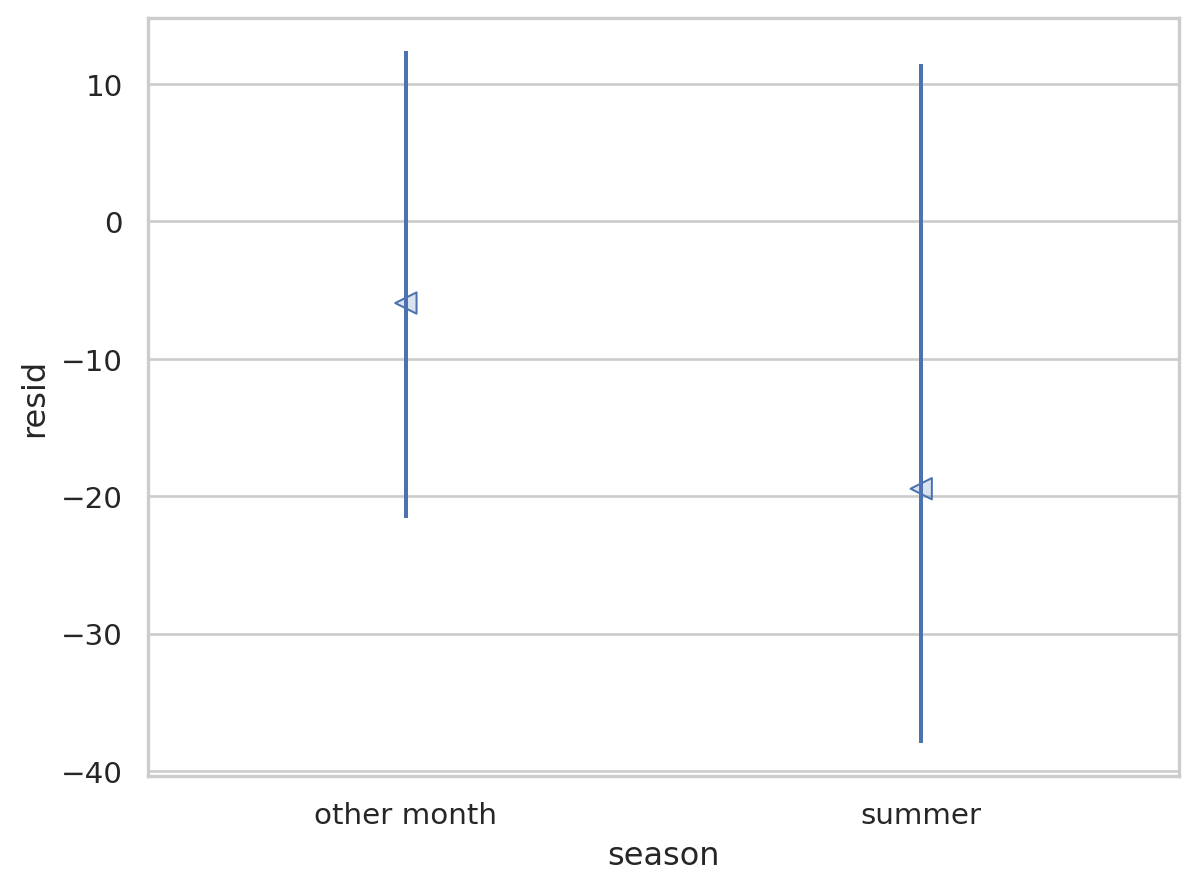

In [ ]:
season

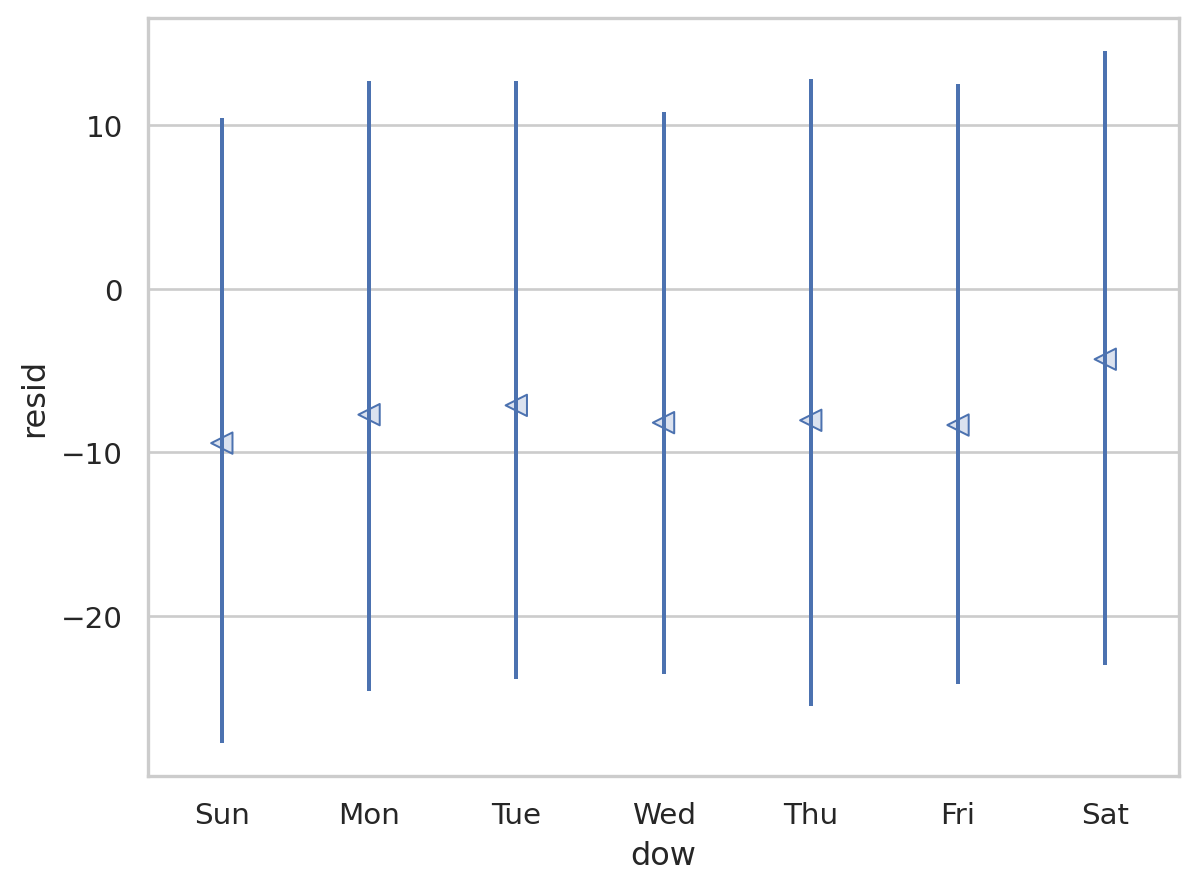

In [ ]:
dow

비행 연착이 변수 각각의 고유한 효과를 보기 위해 예측변수를 포함하는 모형 세우기

In [ ]:
# mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()
mod1 = ols("arr_delay ~ hour", data=sfo).fit()
mod2 = ols("arr_delay ~ hour + origin", data=sfo).fit()
mod3 = ols("arr_delay ~ hour + origin + carrier", data=sfo).fit()
mod4 = ols("arr_delay ~ hour + origin + carrier + season", data=sfo).fit()
mod5 = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

# mod.params

In [ ]:
mod1.params

Intercept   -22.98
hour          2.00
dtype: float64

In [ ]:
mod2.params

Intercept          -26.86
season[T.summer]    24.43
hour                 1.96
dtype: float64

In [ ]:
mod3.params

Intercept    -18.20
dow[T.Mon]    -3.13
dow[T.Tue]    -6.29
              ...  
dow[T.Fri]    -5.63
dow[T.Sat]   -11.00
hour           1.98
Length: 8, dtype: float64

<ipython-input-227-9251b25cd607>:9: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sfo_mods = sfo_mods.melt(


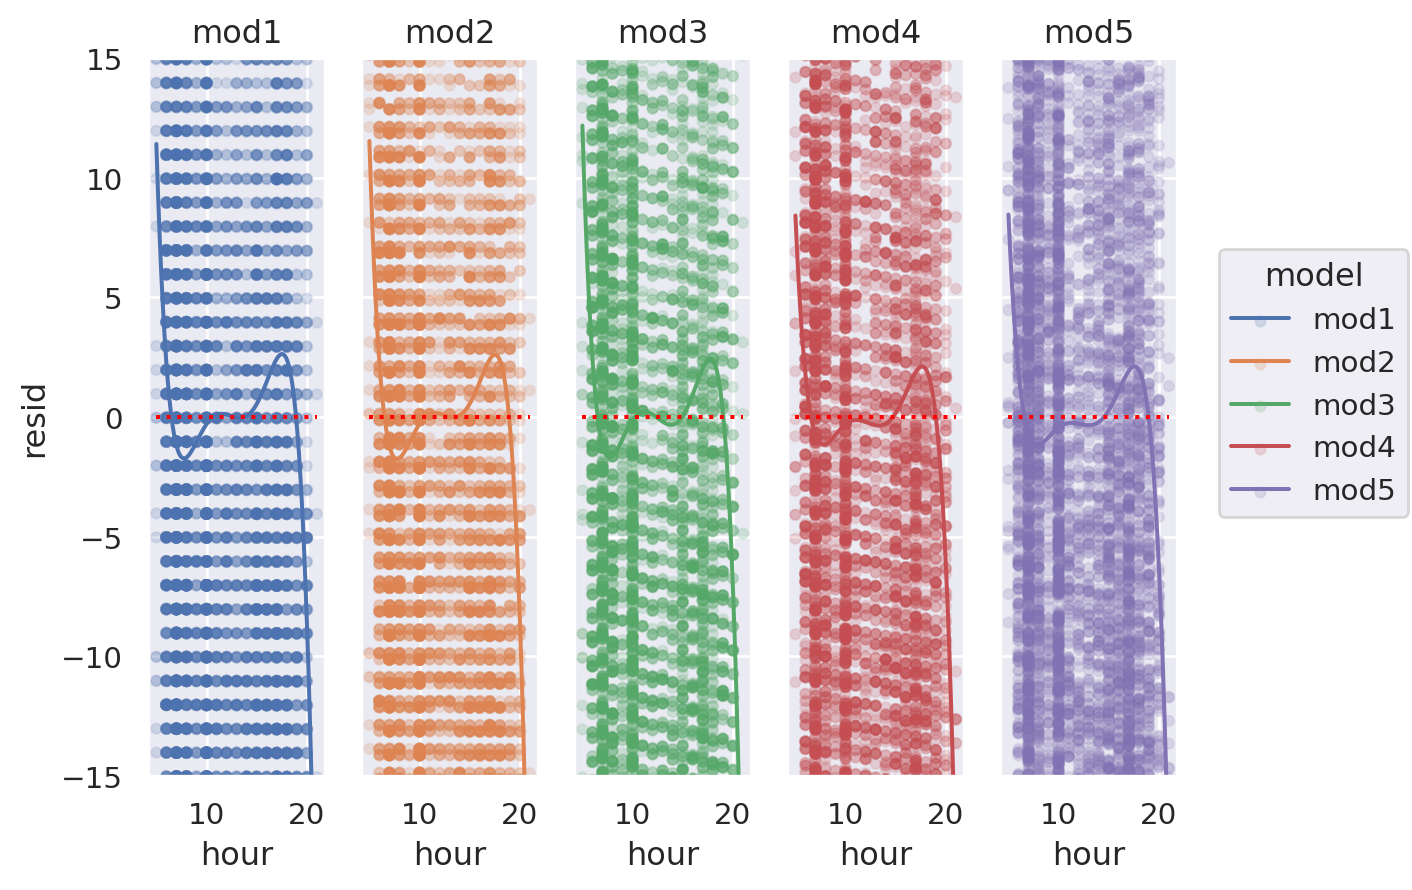

In [ ]:
sfo_mods = sfo.assign(
    mod1=mod1.resid,
    mod2=mod2.resid,
    mod3=mod3.resid,
    mod4=mod4.resid,
    mod5=mod5.resid,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay"],
    value_vars=["mod1", "mod2", "mod3","mod4","mod5"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(sfo_mods, x='hour', y='resid', color='model')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .facet("model")
    #.layout(size=(8, 5))
    .limit(y=(-15,15))
)

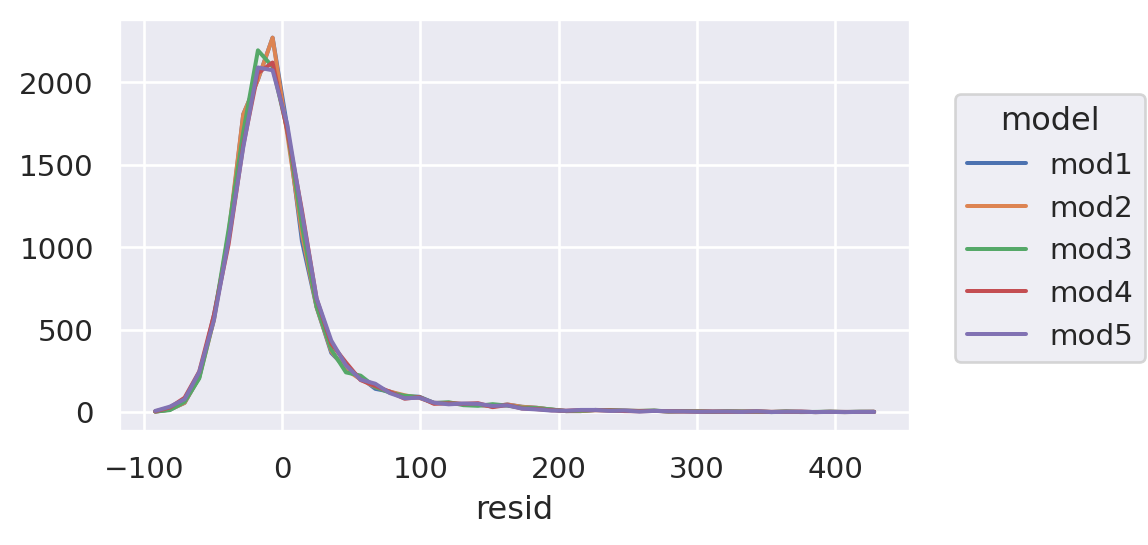

In [ ]:
(
    so.Plot(sfo_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [mod1, mod2, mod3, mod4, mod5]
y = sfo.arr_delay
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.04, RMSE: 45.04, MAE:28.54
R-squared: 0.04, RMSE: 45.04, MAE:28.55
R-squared: 0.05, RMSE: 44.78, MAE:28.50
R-squared: 0.09, RMSE: 43.77, MAE:28.33
R-squared: 0.10, RMSE: 43.65, MAE:28.27


샌프란시스코 연기 됐을때 이유 변수 넣는 이유
파라미터 들여다 보기 
인터렉션 없는데 있으면 들여다보기 
시즌하고...무언가...
변수가 추가될떄마다 모델이 좋아져?
5개의 변수가 상대적 중요도
딜레이에 가장 크게 임팩트 된것이 어떤것?
렐러티비 인포스 상대적 중요도 분석 
변수별 모델의 잔차 줄어드는 폭을 살펴보면 중요도를 알 수 있음.  모델 비교하면서 변수들의 임팩트 살펴보기 

# Interactions

In [ ]:
sfo_mod2 = ols("arr_delay ~ hour + dow", data=sfo).fit()
sfo_mod2_interact = ols("arr_delay ~ hour * dow", data=sfo).fit()

pred 비교

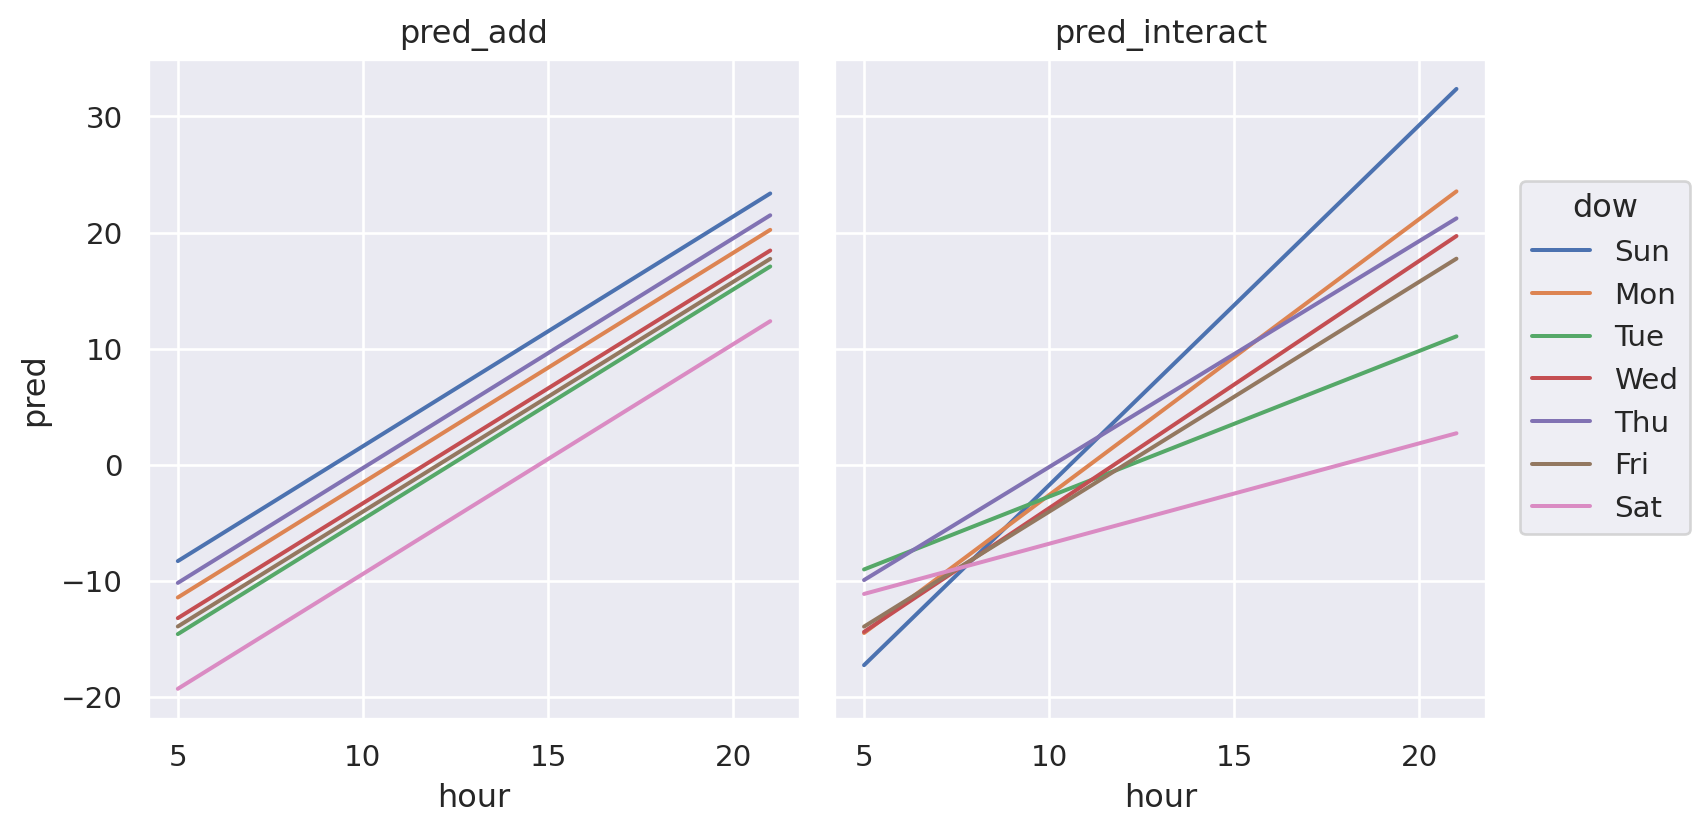

In [ ]:
sfo_mods = sfo.assign(
    pred_add=sfo_mod2.fittedvalues,
    pred_interact=sfo_mod2_interact.fittedvalues,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "dow"],
    value_vars=["pred_add", "pred_interact"],
    var_name="model",
    value_name="pred",
)

(
    so.Plot(sfo_mods, x='hour', y='pred', color='dow')
    .add(so.Line())
    .scale(color=so.Nominal(order=sfo.dow.cat.categories.tolist()))
    .facet("model")
    .layout(size=(8, 4.5))
)

잔차비교

<ipython-input-174-fb2483a46002>:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sfo_mods = sfo_mods.melt(


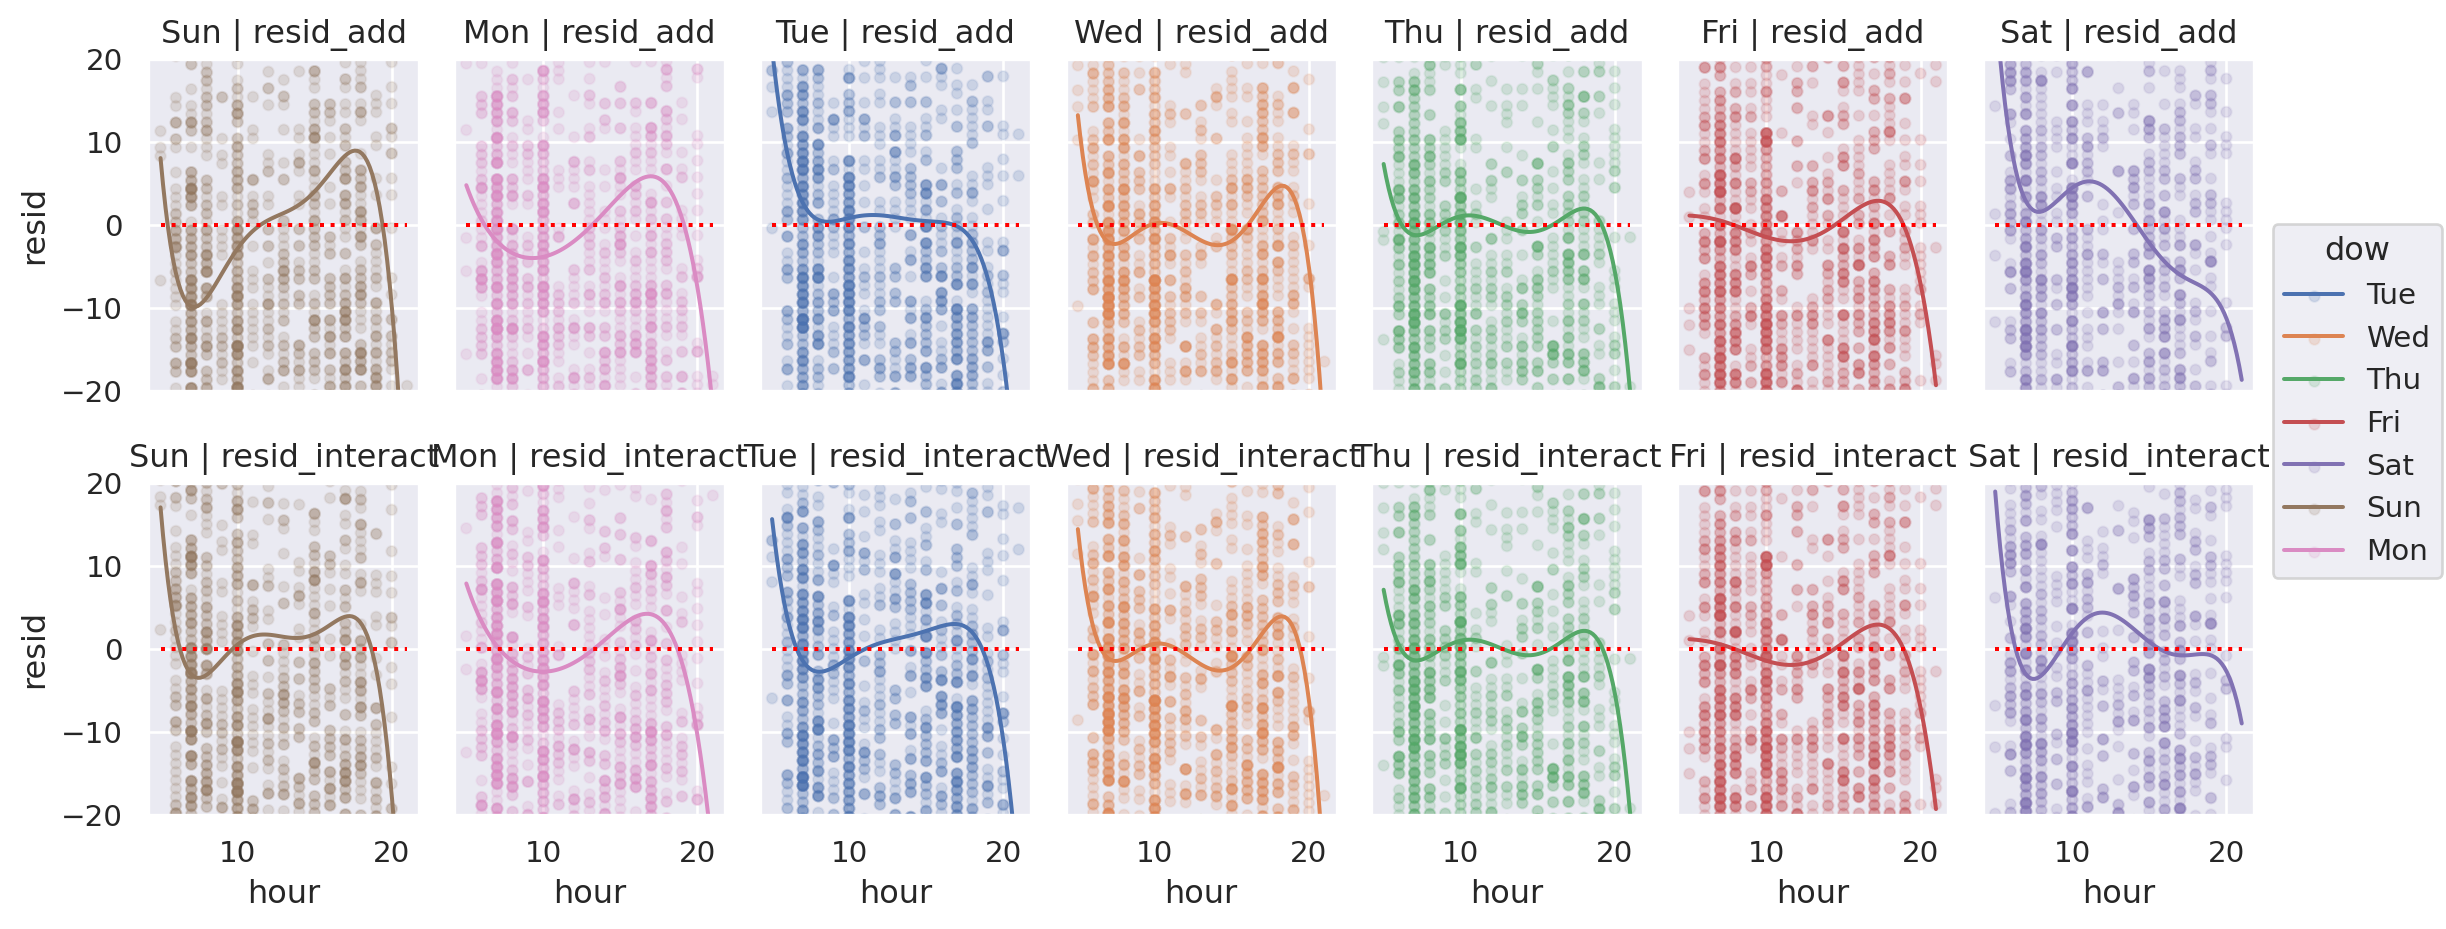

In [ ]:
sfo_mods = sfo.assign(
    resid_add=sfo_mod2.resid,
    resid_interact=sfo_mod2_interact.resid,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "dow"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(sfo_mods, x='hour', y='resid', color='dow')
    .add(so.Dots(alpha=.1))
    .layout(size=(12, 5))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-20,20))
    .facet("dow", "model")
)

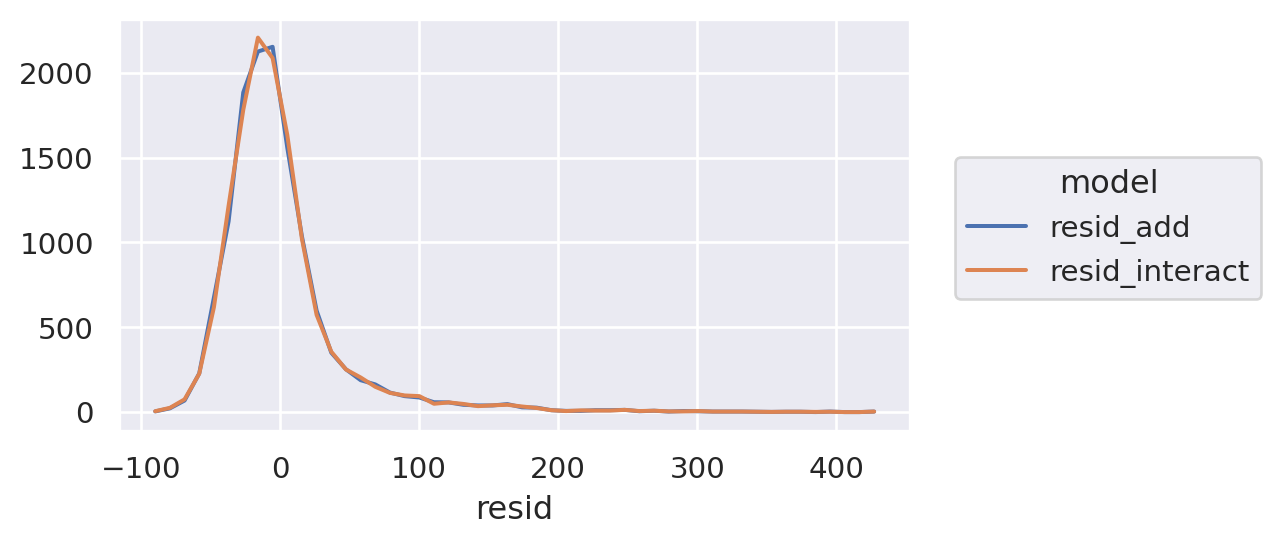

In [ ]:
(
    so.Plot(sfo_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [sfo_mod2,sfo_mod2_interact]
y = sfo.arr_delay
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.04, RMSE: 44.93, MAE:28.52
R-squared: 0.05, RMSE: 44.84, MAE:28.45


In [ ]:
sfo_mod3 = ols("arr_delay ~ hour + season", data=sfo).fit()
sfo_mod3_interact = ols("arr_delay ~ hour * season", data=sfo).fit()

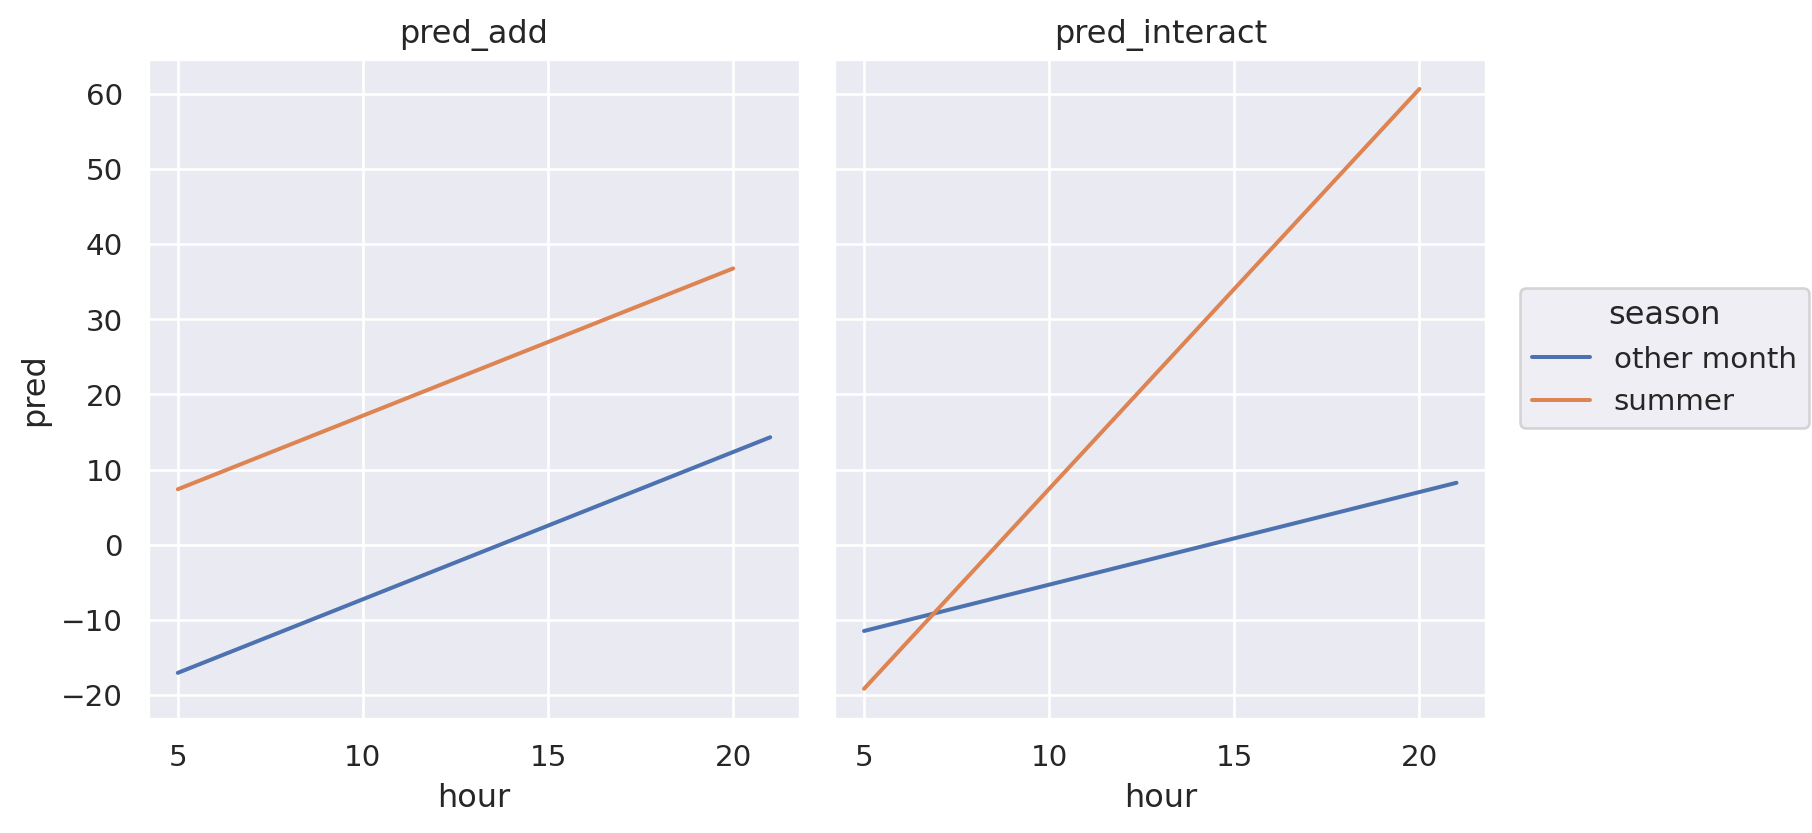

In [ ]:
sfo_mods = sfo.assign(
    pred_add=sfo_mod3.fittedvalues,
    pred_interact=sfo_mod3_interact.fittedvalues,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "season"],
    value_vars=["pred_add", "pred_interact"],
    var_name="model",
    value_name="pred",
)

(
    so.Plot(sfo_mods, x='hour', y='pred', color='season')
    .add(so.Line())
    #.scale(color=so.Nominal(order=sfo.season.cat.categories.tolist()))
    .facet("model")
    .layout(size=(8, 4.5))
)

<ipython-input-179-4dd64f6f5fb0>:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sfo_mods = sfo_mods.melt(


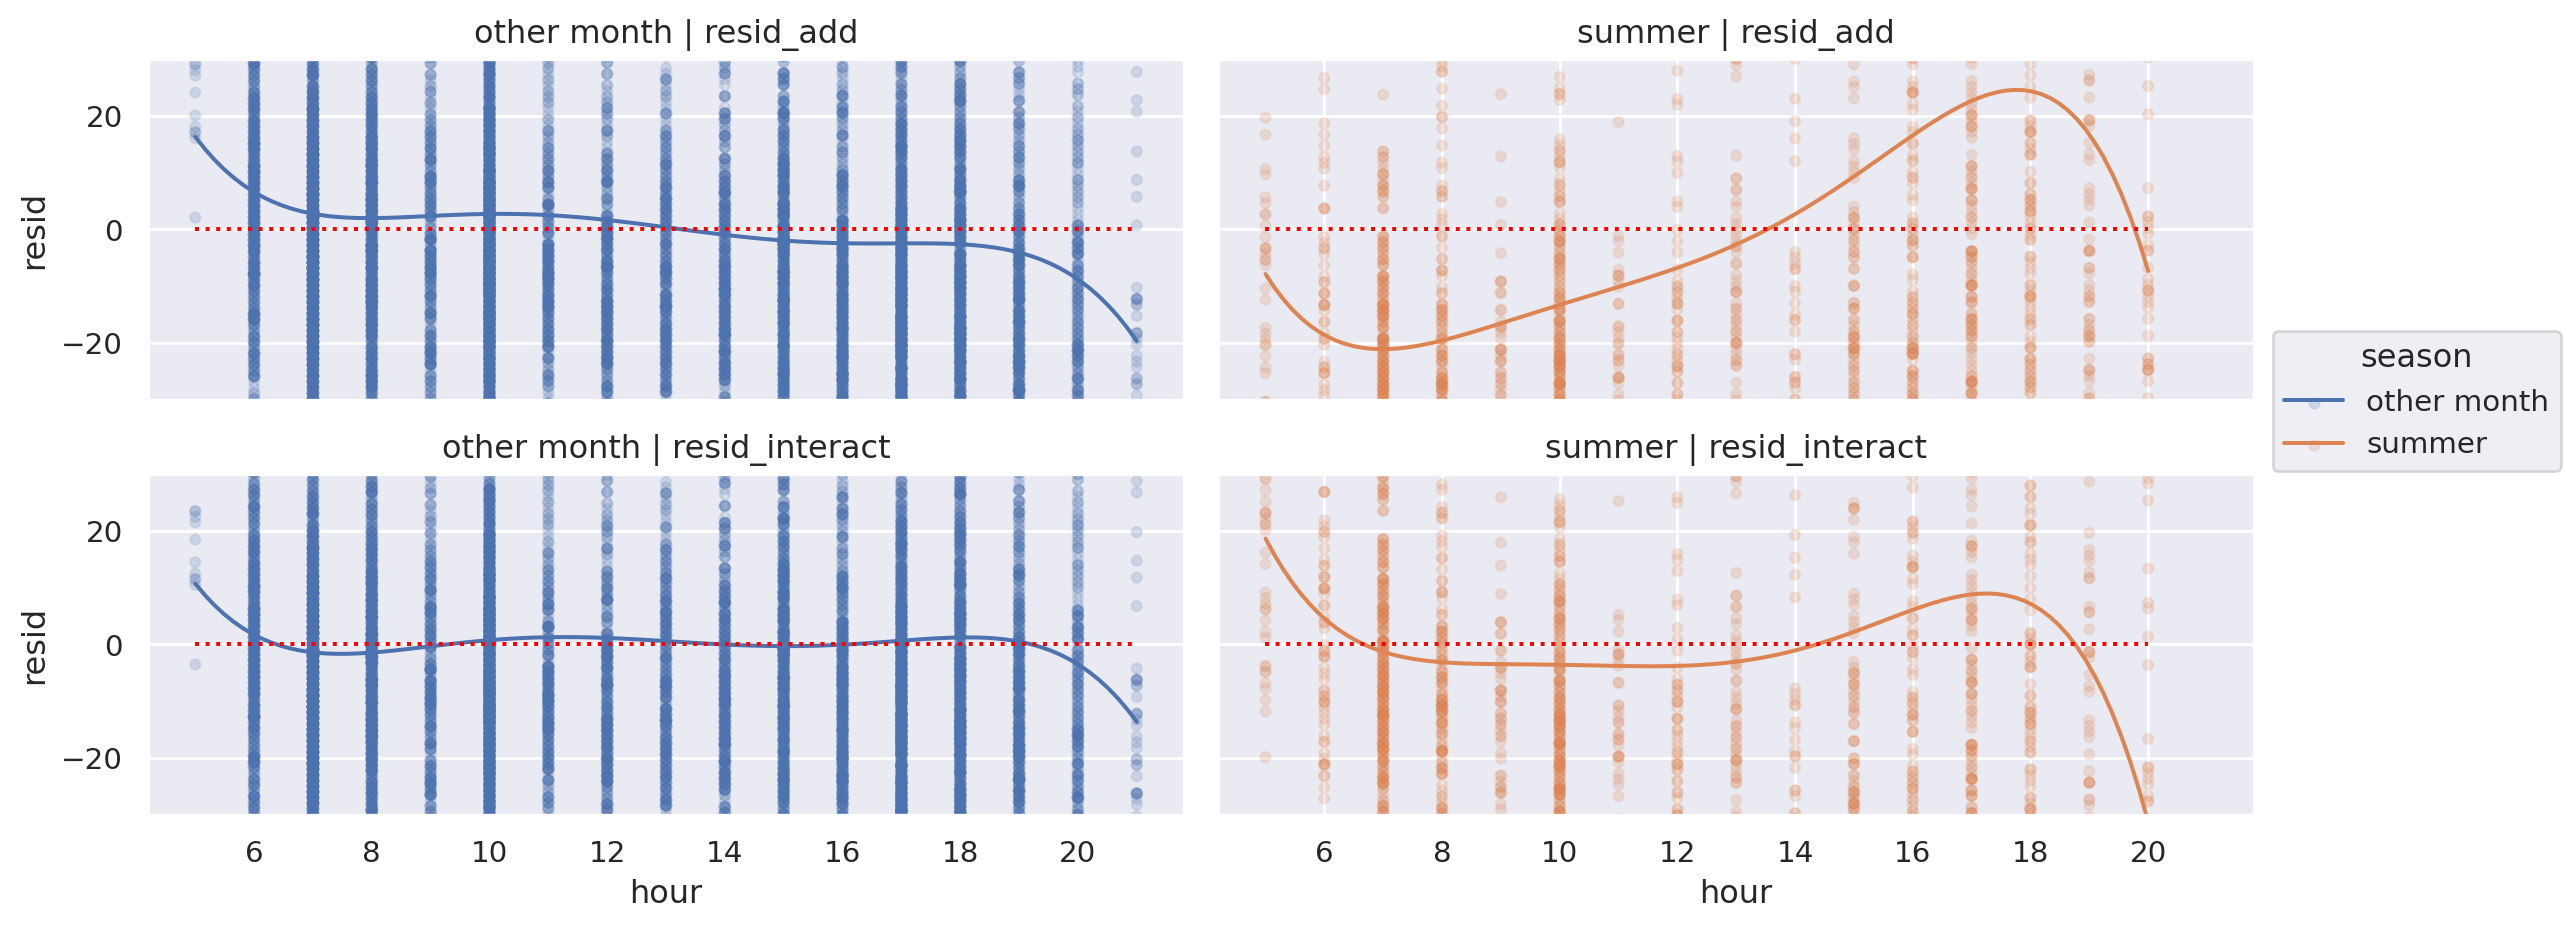

In [ ]:
sfo_mods = sfo.assign(
    resid_add=sfo_mod3.resid,
    resid_interact=sfo_mod3_interact.resid,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "season"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(sfo_mods, x='hour', y='resid', color='season')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-30,30))
    .layout(size=(12, 5))
    .facet("season", "model")
)

여름과 여름이 아닌것을 보면 해당 잔차들이
비행기의 지연 패턴에 영향을 준다고 볼 수 있음

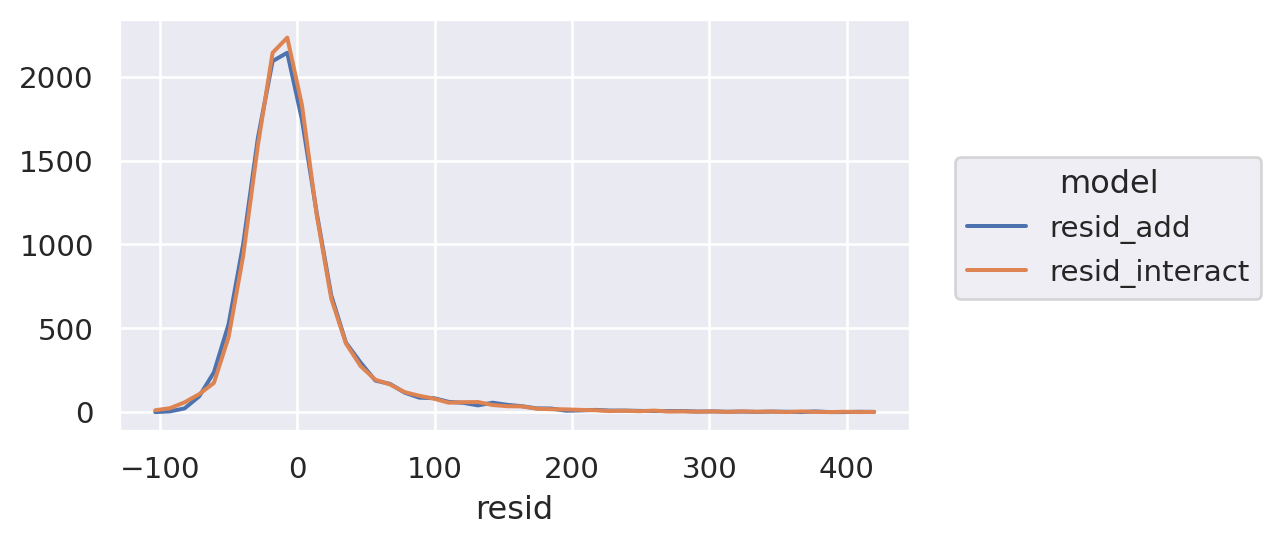

In [ ]:
(
    so.Plot(sfo_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [sfo_mod3,sfo_mod3_interact]
y = sfo.arr_delay
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.08, RMSE: 44.05, MAE:28.41
R-squared: 0.10, RMSE: 43.50, MAE:27.88


여름에는 해가 일찍 뜨고 늦게 진다.
따라서 하루의 해가 뜨고 지는 시간과 상호작용 할 수 있다고 볼 수있나?
=> 사실은 여름에 휴가철이라 비행기가 많이 뜨는것

In [ ]:
sfo_mod4 = ols("arr_delay ~ hour + season + dow", data=sfo).fit()
sfo_mod4_interact = ols("arr_delay ~ hour * season * dow", data=sfo).fit()

<ipython-input-182-37747ef38787>:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sfo_mods = sfo_mods.melt(


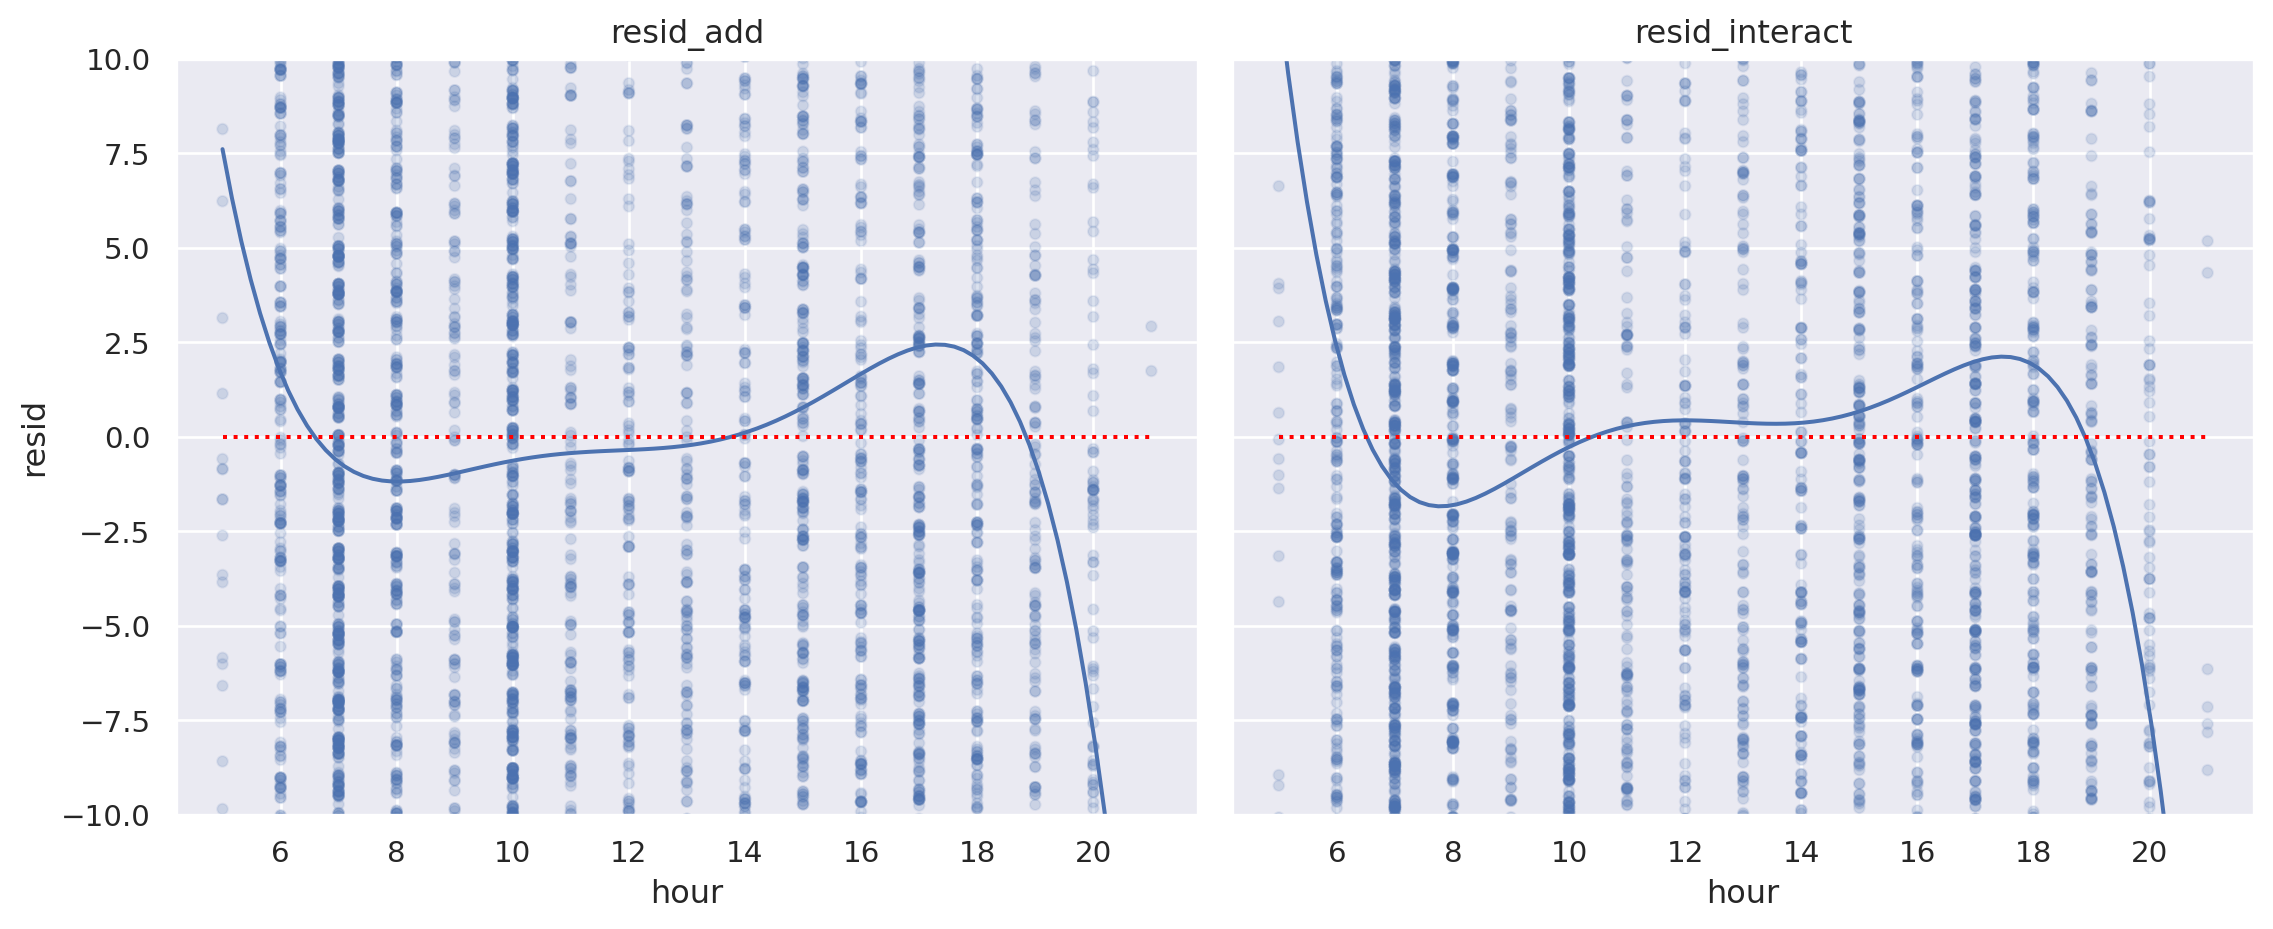

In [ ]:
sfo_mods = sfo.assign(
    resid_add=sfo_mod4.resid,
    resid_interact=sfo_mod4_interact.resid,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "season", "dow"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(sfo_mods, x='hour', y='resid')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-10,10))
    .layout(size=(12, 5))
    .facet("model")
)

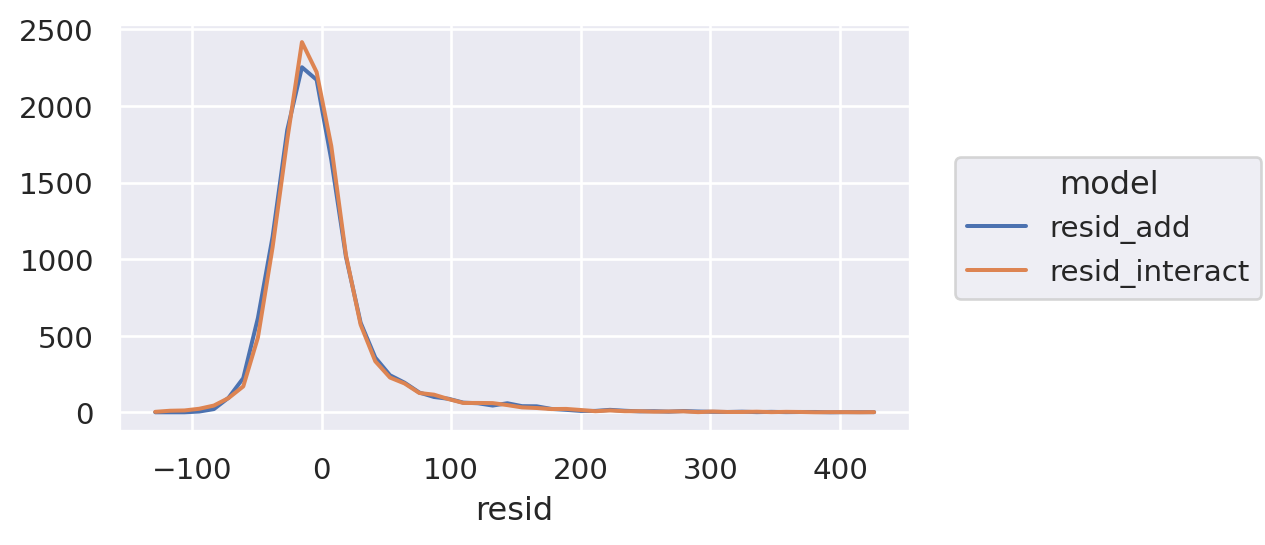

In [ ]:
(
    so.Plot(sfo_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [sfo_mod4, sfo_mod4_interact]
y = sfo.arr_delay
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.08, RMSE: 43.94, MAE:28.36
R-squared: 0.12, RMSE: 43.05, MAE:27.59


In [ ]:
sfo_modf = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()
sfo_modf_interact= ols("arr_delay ~ hour * origin * carrier * season * dow", data=sfo).fit()

<ipython-input-185-85dad5c345f0>:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sfo_mods = sfo_mods.melt(


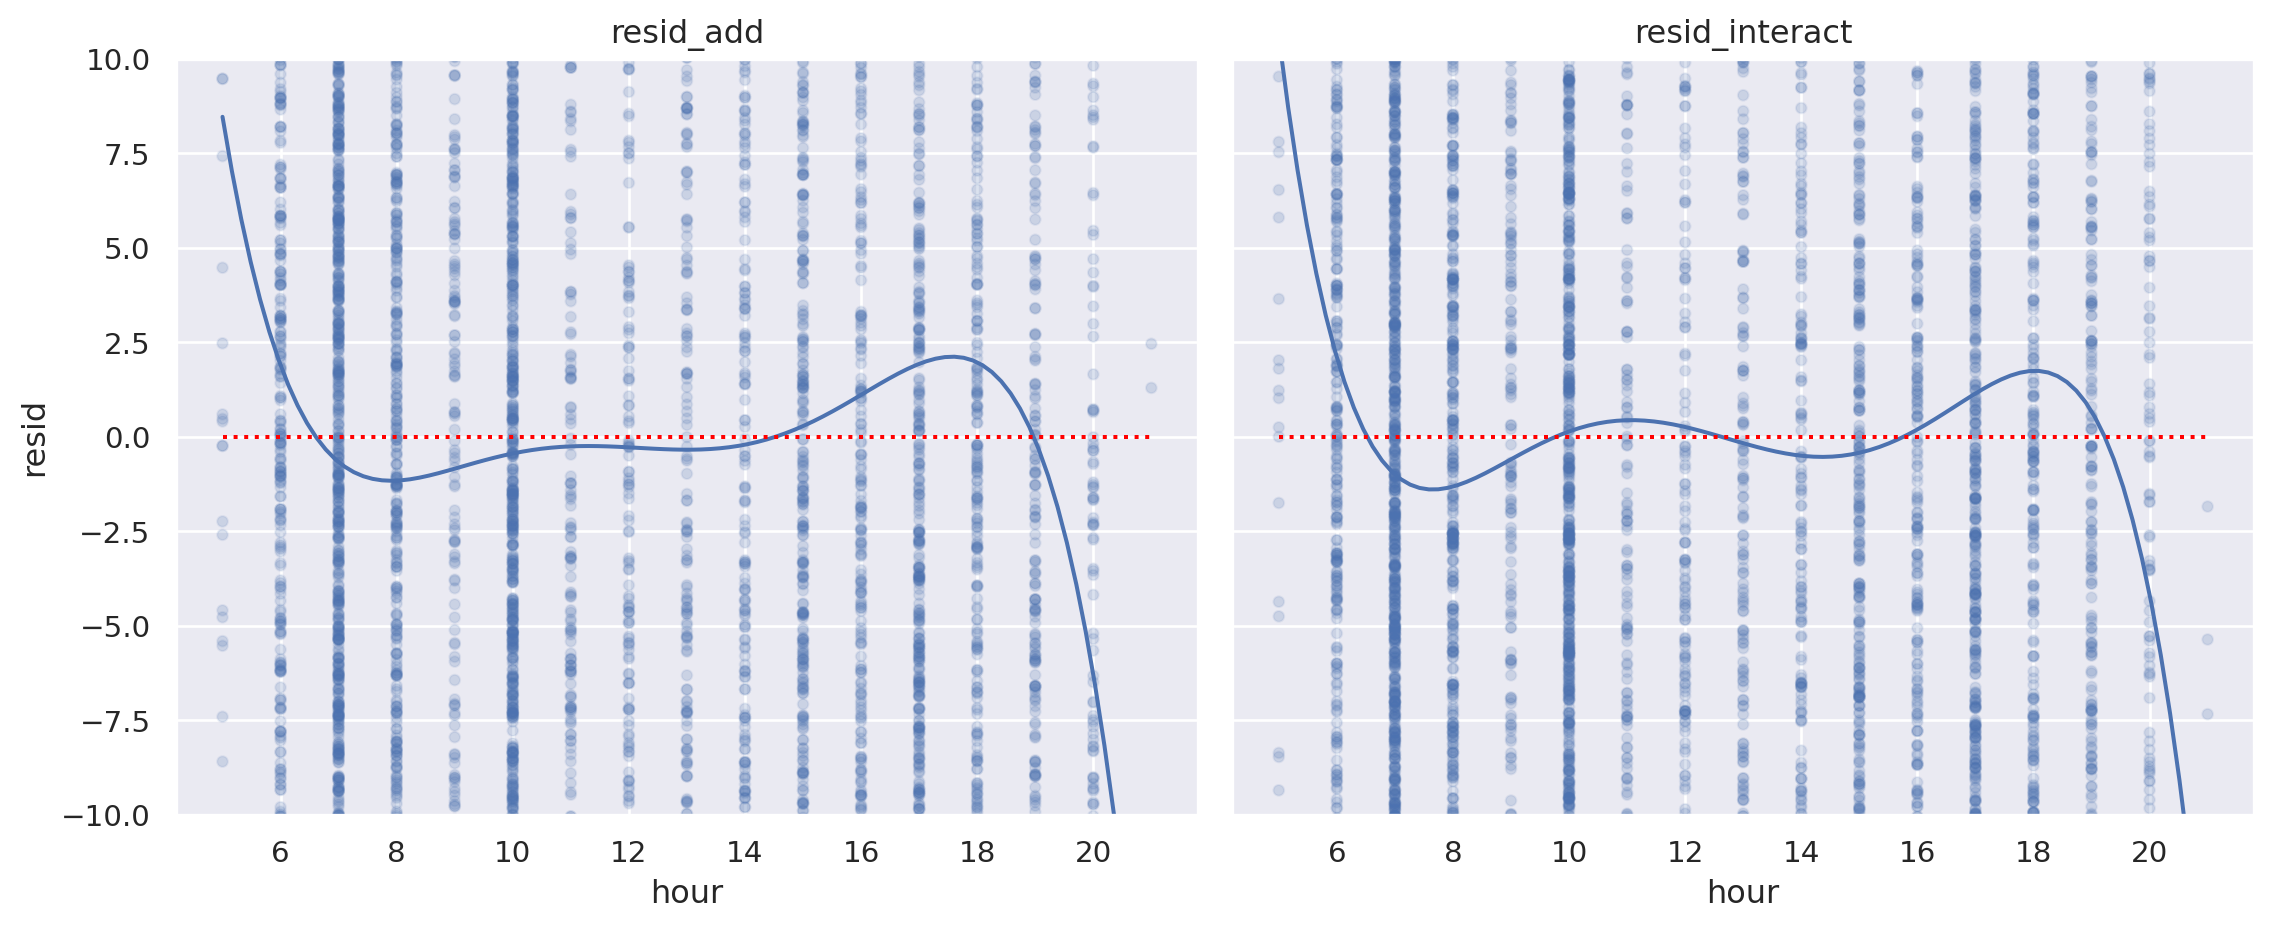

In [ ]:
sfo_mods = sfo.assign(
    resid_add=sfo_modf.resid,
    resid_interact=sfo_modf_interact.resid,
)

sfo_mods = sfo_mods.melt(
    id_vars=["hour", "arr_delay", "season", "dow","origin","carrier"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(sfo_mods, x='hour', y='resid')
    .add(so.Dots(alpha=.1))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .limit(y=(-10,10))
    .layout(size=(12, 5))
    .facet("model")
    
)

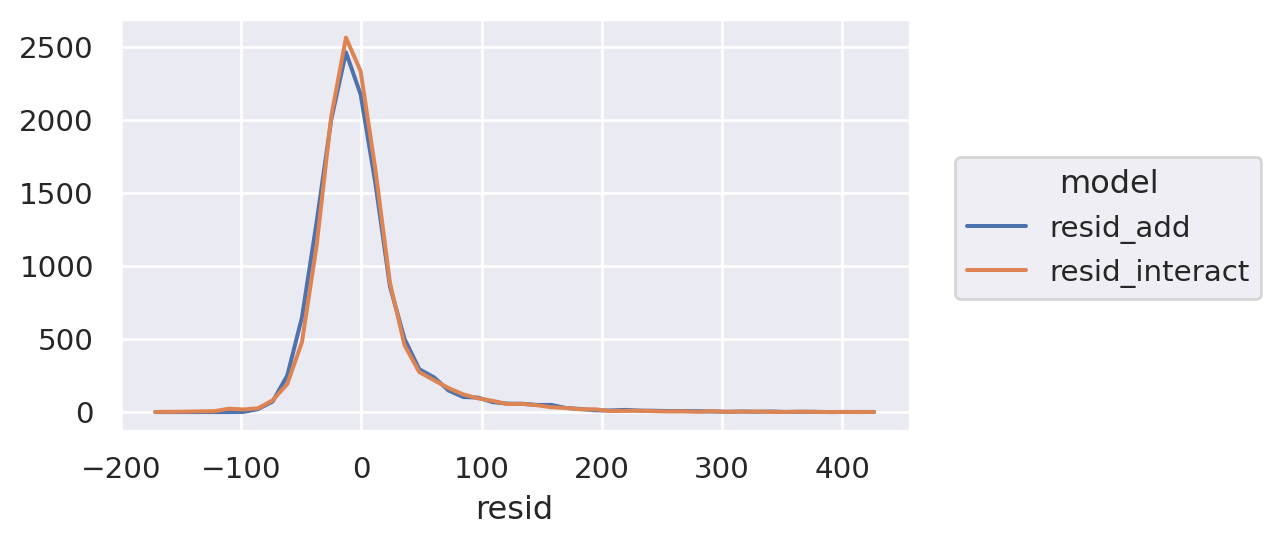

In [ ]:
(
    so.Plot(sfo_mods, x='resid', color='model')
    .add(so.Line(), so.Hist(bins=50))
    .layout(size=(5, 3))
)

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [sfo_modf, sfo_modf_interact]
y = sfo.arr_delay
print("The prediction accuracy of the models (original unit except R-squared):\n")

for mod in mods:
    y_hat = mod.fittedvalues
    R2 = mod.rsquared

    print(
        f"R-squared: {R2:.2f}, RMSE: {rmse(y, y_hat):.2f}, "
        f"MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

R-squared: 0.10, RMSE: 43.65, MAE:28.27
R-squared: 0.16, RMSE: 42.07, MAE:27.10
